<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_9/Assignment_9_(unmodularized).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-z6or6bat
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-z6or6bat
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98521 sha256=8ce0301418849f4933f91ba68db4bdc1ab59d160a5d6c2b6716dec40ffc69745
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8rlwbmu/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

# Let's visualize some of the images
%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import copy

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

In [ ]:
class resnet(nn.Module): 
    def __init__(self):
        super(resnet, self).__init__()

        self.preplayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(),  
        )

        self.x1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.layer2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),  
        )

        self.x3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(),  
        )

        self.res3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.max4d = nn.MaxPool2d(4, 4)

        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):

        prep_layer = self.preplayer(x)

        x1 = self.x1(prep_layer)
        R1 = self.res1(x1)
        layer1 = x1 + R1

        layer2 = self.layer2(layer1)

        x3 = self.x3(layer2)
        R3 = self.res3(x3)
        layer3 = x3 + R3

        maxpool = self.max4d(layer3)

        x = maxpool.view(maxpool.size(0),-1)
        fc = self.fc(x)
        softmax = F.log_softmax(fc.view(-1,10), dim=-1)
        
        return softmax

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [ ]:
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

print(train_data.data.mean(axis=(0, 1, 2))/255)

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]


In [ ]:
len(train_data)

50000

In [ ]:
train_data.data.shape

(50000, 32, 32, 3)

### **Transformations**

* **Transformations used on Train Data**
  * RandomCrop 32, 32 (after padding of 4)
  * FlipLR 
  * CutOut(8, 8)
  

* References:
  * [albumentation_doocs](https://albumentations.ai/docs/examples/pytorch_classification/)
  * [video_tutorial](https://www.youtube.com/watch?v=rAdLwKJBvPM&ab_channel=AladdinPersson)
  * [albumentations_classes](https://albumentations.ai/docs/api_reference/augmentations/transforms/)

In [ ]:
train_transform = A.Compose([     
            A.Sequential([
                   A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by defaulf
                   A.RandomCrop(32,32)
                   ]),
            A.HorizontalFlip(p=0.7),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
            ToTensorV2(),
        ])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
train_transform = Transforms(train_transform)
test_transform = Transforms(test_transform)

### **Download And Load Train, Test Data**

In [ ]:
train = datasets.CIFAR10(root='/content/data', train=True,
                        download=True, transform=train_transform)
test = datasets.CIFAR10(root='/content/data',train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=512, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=512,  
                                          shuffle=False,
                                          num_workers=2, 
                                          pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

## Once Cycle Policy


In [ ]:
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.CrossEntropyLoss()
model = resnet().to(device)
momemtum = 0.9
weight_decay=0.05,
Lrtest_train_acc = []
LRtest_Lr = []



In [ ]:
step = (max_lr - min_lr )/epoch
lr = min_lr
for e in range(epoch):
    testmodel = copy.deepcopy(model)
    optimizer = optim.SGD(testmodel.parameters(), lr=lr ,momentum=0.9,weight_decay=0.05 ) 
    lr += (max_lr - min_lr)/epoch
    testmodel.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data["image"].to(device), target.to(device)
        optimizer.zero_grad()
        y_pred =testmodel(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'epoch = {e+1} Lr = {optimizer.param_groups[0]["lr"]}  Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    Lrtest_train_acc.append(100*correct/processed)
    LRtest_Lr.append(optimizer.param_groups[0]['lr'])

epoch = 1 Lr = 0.001  Loss=1.550249695777893 Batch_id=97 Accuracy=32.54: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
epoch = 2 Lr = 0.0029  Loss=1.4849601984024048 Batch_id=97 Accuracy=36.71: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]
epoch = 3 Lr = 0.0048  Loss=1.377687692642212 Batch_id=97 Accuracy=35.53: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
epoch = 4 Lr = 0.006699999999999999  Loss=1.6627634763717651 Batch_id=97 Accuracy=27.13: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]
epoch = 5 Lr = 0.0086  Loss=1.7587109804153442 Batch_id=97 Accuracy=22.70: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
epoch = 6 Lr = 0.0105  Loss=1.7244470119476318 Batch_id=97 Accuracy=22.54: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
epoch = 7 Lr = 0.012400000000000001  Loss=1.8090248107910156 Batch_id=97 Accuracy=20.00: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
epoch = 8 Lr = 0.014300000000000002  Loss=2.057267427444458 Batch_id=97 Accuracy=15.00: 100%|██████████| 98/98 [00

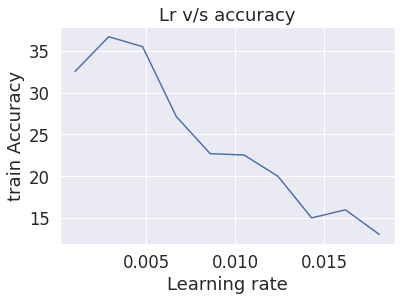

In [ ]:
plt.plot(LRtest_Lr, Lrtest_train_acc)
plt.ylabel('train Accuracy')
plt.xlabel("Learning rate")
plt.title("Lr v/s accuracy")
plt.show()

### **Model Design**

### **Model Summary**

### **Train Function**

In [ ]:
def train(model, device, train_loader, optimizer, scheduler, criterion, train_acc, train_loss):   
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data["image"].to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)

        

        # Backpropagation
        loss.backward()

        optimizer.step()
        scheduler.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
    train_loss.append(loss.data.cpu().numpy().item())
    train_acc.append(100 * correct / processed)

### **Test Function**

In [ ]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### **Train And Test the Model**

In [ ]:
criterion = nn.CrossEntropyLoss()
model = resnet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = OneCycleLR(optimizer, max_lr = 0.012400000000000001    , total_steps=None, epochs=24, steps_per_epoch=len(train_loader), pct_start=0.167, anneal_strategy='linear', 
                       cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
LR = []
for epoch in range(1, 25):
    print("EPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    LR.append(optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy, train_losses)

    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0012400000000000002


Loss=1.4518868923187256 Batch_id=97 Accuracy=35.08: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4955/10000 (49.55%)

EPOCH: 2 LR: 0.004031538194515345


Loss=1.1477816104888916 Batch_id=97 Accuracy=52.64: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5907/10000 (59.07%)

EPOCH: 3 LR: 0.0068230763890306904


Loss=1.0303641557693481 Batch_id=97 Accuracy=60.69: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7063/10000 (70.63%)

EPOCH: 4 LR: 0.009614614583546037


Loss=0.9828583002090454 Batch_id=97 Accuracy=66.64: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7289/10000 (72.89%)

EPOCH: 5 LR: 0.012398769630301102


Loss=0.8007153272628784 Batch_id=97 Accuracy=70.50: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7832/10000 (78.32%)

EPOCH: 6 LR: 0.011840546340985376


Loss=0.8236434459686279 Batch_id=97 Accuracy=75.26: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7785/10000 (77.85%)

EPOCH: 7 LR: 0.011282323051669648


Loss=0.5569260120391846 Batch_id=97 Accuracy=77.75: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)

EPOCH: 8 LR: 0.010724099762353922


Loss=0.6647427082061768 Batch_id=97 Accuracy=79.72: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8256/10000 (82.56%)

EPOCH: 9 LR: 0.010165876473038196


Loss=0.693509578704834 Batch_id=97 Accuracy=81.81: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8257/10000 (82.57%)

EPOCH: 10 LR: 0.00960765318372247


Loss=0.4754926264286041 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8399/10000 (83.99%)

EPOCH: 11 LR: 0.009049429894406744


Loss=0.4912489354610443 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8269/10000 (82.69%)

EPOCH: 12 LR: 0.008491206605091017


Loss=0.45821261405944824 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8638/10000 (86.38%)

EPOCH: 13 LR: 0.00793298331577529


Loss=0.3785838186740875 Batch_id=97 Accuracy=86.07: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8502/10000 (85.02%)

EPOCH: 14 LR: 0.007374760026459565


Loss=0.33560025691986084 Batch_id=97 Accuracy=87.26: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8737/10000 (87.37%)

EPOCH: 15 LR: 0.006816536737143838


Loss=0.2948436439037323 Batch_id=97 Accuracy=88.12: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8888/10000 (88.88%)

EPOCH: 16 LR: 0.006258313447828112


Loss=0.3658577799797058 Batch_id=97 Accuracy=88.79: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8878/10000 (88.78%)

EPOCH: 17 LR: 0.005700090158512386


Loss=0.29768887162208557 Batch_id=97 Accuracy=89.31: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8752/10000 (87.52%)

EPOCH: 18 LR: 0.005141866869196659


Loss=0.2803500294685364 Batch_id=97 Accuracy=89.78: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8850/10000 (88.50%)

EPOCH: 19 LR: 0.004583643579880933


Loss=0.25049862265586853 Batch_id=97 Accuracy=90.61: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8975/10000 (89.75%)

EPOCH: 20 LR: 0.004025420290565206


Loss=0.23058249056339264 Batch_id=97 Accuracy=91.35: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8994/10000 (89.94%)

EPOCH: 21 LR: 0.0034671970012494797


Loss=0.2315424084663391 Batch_id=97 Accuracy=91.90: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8988/10000 (89.88%)

EPOCH: 22 LR: 0.002908973711933752


Loss=0.23337122797966003 Batch_id=97 Accuracy=92.23: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9070/10000 (90.70%)

EPOCH: 23 LR: 0.002350750422618026


Loss=0.21399202942848206 Batch_id=97 Accuracy=92.99: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9120/10000 (91.20%)

EPOCH: 24 LR: 0.0017925271333023001


Loss=0.20310457050800323 Batch_id=97 Accuracy=93.56: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.0005, Accuracy: 9116/10000 (91.16%)



### **Train, Validation Loss and Accuracy Plots**

In [ ]:
LR

[0.0012400000000000002,
 0.004031538194515345,
 0.0068230763890306904,
 0.009614614583546037,
 0.012398769630301102,
 0.011840546340985376,
 0.011282323051669648,
 0.010724099762353922,
 0.010165876473038196,
 0.00960765318372247,
 0.009049429894406744,
 0.008491206605091017,
 0.00793298331577529,
 0.007374760026459565,
 0.006816536737143838,
 0.006258313447828112,
 0.005700090158512386,
 0.005141866869196659,
 0.004583643579880933,
 0.004025420290565206,
 0.0034671970012494797,
 0.002908973711933752,
 0.002350750422618026,
 0.0017925271333023001]

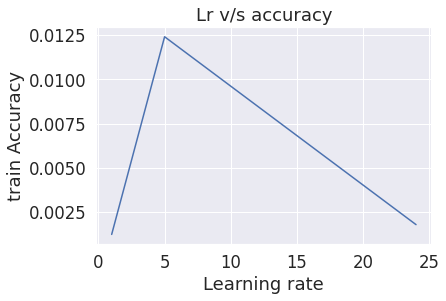

In [ ]:
plt.plot(np.arange(1,25),LR)
plt.ylabel('train Accuracy')
plt.xlabel("Learning rate")
plt.title("Lr v/s accuracy")
plt.show()

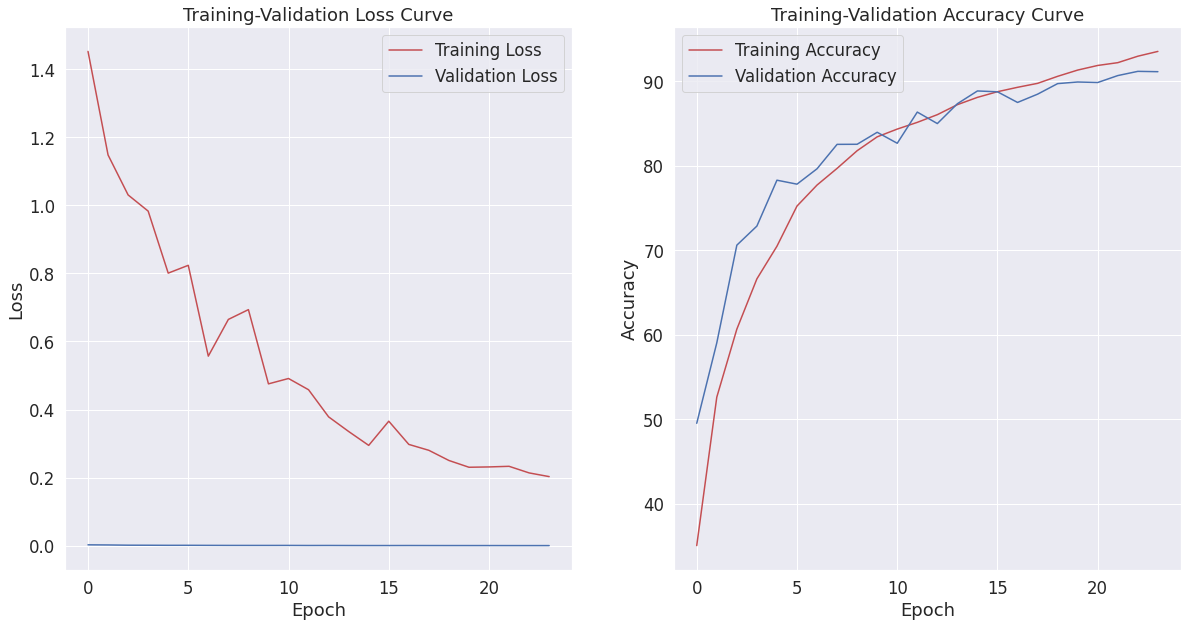

In [ ]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(train_losses, 'r', label="Training Loss")
plt1.plot(test_losses, 'b', label="Validation Loss")
plt2.plot(train_accuracy, 'r', label="Training Accuracy")
plt2.plot(test_accuracy, 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Classwise Predictions**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 58 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


In [ ]:
wrong_images = []
wrong_label = []
correct_label = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data["image"].to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()

        wrong_pred = (pred.eq(target.view_as(pred)) == False)
        wrong_images.append(data[wrong_pred])
        wrong_label.append(pred[wrong_pred])
        correct_label.append(target.view_as(pred)[wrong_pred])

        wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
    print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


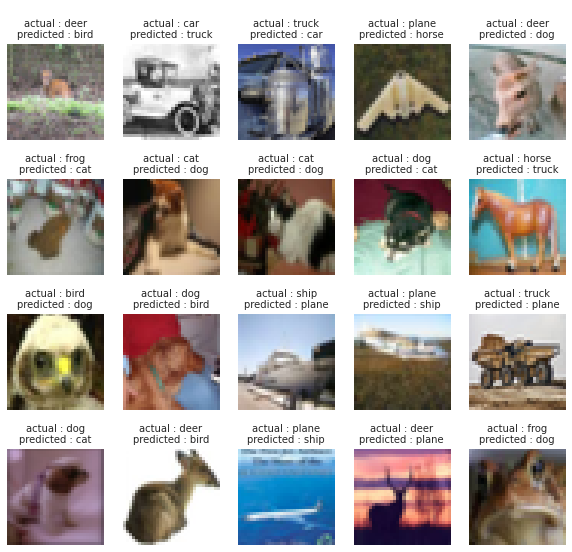

In [ ]:
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()

mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

for i, (img, pred, correct) in enumerate(wrong_predictions[:20]):
    img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
    for j in range(img.shape[0]):
        img[j] = (img[j] * std[j]) + mean[j]

    img = np.transpose(img, (1, 2, 0))  # / 2 + 0.5
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.set_title(f'\nactual : {classes[target.item()]}\npredicted : {classes[pred.item()]}',
                  fontsize=10)
    ax.imshow(img)

plt.show()